In [1]:
%load_ext autoreload
%autoreload 2

<div class="alert alert-block alert-success">

# Contents

* [1. Imports](#imports)


* [2. Data pre-processing](#data)


* [3. Training example and plotting results](#training)


* [4. Hyperparameter tuning](#hp)


* [5. Control region](#cr)


* [6. Some remarks](#remarks)

# <a id="imports"></a>  1. Imports

In [2]:
# avoids running on GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# hep imports
import mplhep as hep
hep.style.use('ATLAS')
from hh4b_utils.nnt_tools import load_nnt

# standard libraries imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization, Objective

# import shap to visualise feature importance
import shap
import ipywidgets as widgets

# import utils.py
import utils

2021-09-26 22:56:57.426104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# <a id="data"></a>  2. Data pre-processing

In [3]:
# mc files
file_path_mc_16 = "/mnt/storage/zcapxke/data/sm_hh_pythia_mc16a.root"
file_path_mc_17 = "/mnt/storage/zcapxke/data/sm_hh_pythia_mc16d.root"
file_path_mc_18 = "/mnt/storage/zcapxke/data/sm_hh_pythia_mc16e.root"
# get data
mc16,mc17,mc18=utils.get_data(file_path_mc_16,file_path_mc_17,file_path_mc_18,region='sig',mc=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


In [4]:
# data files
file_path_data_16 = "/mnt/storage/zcapxke/data/data16_Xhh_45_NN_100_bootstraps.root"
file_path_data_17 = "/mnt/storage/zcapxke/data/data17_Xhh_45_NN_100_bootstraps.root"
file_path_data_18 = "/mnt/storage/zcapxke/data/data18_Xhh_45_NN_100_bootstraps.root"
# get data
data16,data17,data18=utils.get_data(file_path_data_16,file_path_data_17,file_path_data_18,region='sig')

100%|████████████████████████████████████████████████████████████████████████████████████████| 466/466 [01:40<00:00,  4.62it/s]


In [5]:
# apply masks
signal_df = utils.get_data_mask(mc16,mc17,mc18,mask='4b')
bkg_df = utils.get_data_mask(data16,data17,data18,mask='2bRW')

In [6]:
# excluding some features that did not agree well in CR
features = ['m_hh','X_hh','dEta_hh','njets','X_wt_tag','cos_theta_star',
           'pt_hh','pT_2','pT_4','eta_i','dRjj_1','dRjj_2','m_min_dj','m_max_dj',
          'pairing_score_1','pairing_score_2','bkt_lead_jet_pt','bkt_third_lead_jet_pt',
          'm_h1','E_h1','pT_h1','eta_h1','phi_h1','m_h2','E_h2','pT_h2','eta_h2','phi_h2',
          'm_h1_j1','E_h1_j1','eta_h1_j1','phi_h1_j1',
           'm_h1_j2','E_h1_j2','eta_h1_j2','phi_h1_j2',
          'm_h2_j1','E_h2_j1','eta_h2_j1','phi_h2_j1',
           'm_h2_j2','E_h2_j2','eta_h2_j2','phi_h2_j2','year'] 

# final dataset
df_data = pd.concat([signal_df, bkg_df], ignore_index=True)
X = df_data[features]
y = df_data['class']
idx = df_data.index
weights = df_data['sample_weight']

In [7]:
# train 70%, valitation 15% and test 15% of the dataset
(
    X_train,
    X_test_validate,
    y_train,
    y_test_validate,
    weights_train,
    weights_test_validate,
    idx_train,
    idx_test_validate,
) = train_test_split(X, y, weights, list(idx), test_size=0.3)
(
    X_test,
    X_val,
    y_test,
    y_val,
    weights_test,
    weights_val,
    idx_test,
    idx_val,
) = train_test_split(
    X_test_validate,
    y_test_validate,
    weights_test_validate,
    idx_test_validate,
    test_size=0.5,
)

In [8]:
print(X_train.shape)
print(X_test_validate.shape)
print(y_train.shape)
print(y_test_validate.shape)
print(len(idx_train))
print(len(idx_test_validate))

(610090, 45)
(261468, 45)
(610090,)
(261468,)
610090
261468


In [9]:
# scale X
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)
# convert y to binary class matrix
y_train_hot = to_categorical(y_train)
y_val_hot = to_categorical(y_val)
y_test_hot = to_categorical(y_test)

# weights for classes
N_bkg_train = weights_train[y_train == 0].sum()
N_sig_train = weights_train[y_train==1].sum()
# ratio of the weights
R = N_bkg_train / N_sig_train
# use this ratio for signal events
weights_train_R = np.copy(weights_train)
weights_train_R[y_train==1] = R

# <a id="training"></a> 3. Training example and plotting results

In [15]:
# create deep NN model
model = Sequential()
model.add(Dense(200, input_dim=len(features), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

2021-09-24 23:50:11.386510: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-24 23:50:11.436971: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-24 23:50:11.448438: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gpu01
2021-09-24 23:50:11.448591: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gpu01
2021-09-24 23:50:11.458372: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2021-09-24 23:50:11.459356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2021-09-24 23:50:11.459377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.32.3
2021-09-24 23:50:11.472259: I tensorflow/core/platform/cpu_feature_guard

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               9200      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 49,802
Trainable params: 49,802
Non-trainable params: 0
_________________________________________________________________


In [19]:
# choose adam optimizer and compile model
# note, could have used utils.F1_Score() in metric
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [20]:
history = model.fit(
    X_train_sc,
    y_train_hot,
    sample_weight=weights_train_R,
    epochs=100,
    # early stopping set
    callbacks=[EarlyStopping(monitor="val_loss", patience=15, verbose=True)],
    batch_size=1000,
    # validation data
    validation_data=(X_val_sc, y_val_hot, weights_val),
)

2021-09-24 23:55:07.936666: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-24 23:55:07.947479: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3200235000 Hz


Epoch 1/100
611/611 [==============================] - 5s 6ms/step - loss: 0.0165 - accuracy: 0.7155 - val_loss: 0.0501 - val_accuracy: 0.7106
Epoch 2/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0150 - accuracy: 0.7281 - val_loss: 0.0473 - val_accuracy: 0.7239
Epoch 3/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0145 - accuracy: 0.7385 - val_loss: 0.0522 - val_accuracy: 0.7693
Epoch 4/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0142 - accuracy: 0.7492 - val_loss: 0.0459 - val_accuracy: 0.7610
Epoch 5/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0138 - accuracy: 0.7628 - val_loss: 0.0430 - val_accuracy: 0.7591
Epoch 6/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0135 - accuracy: 0.7748 - val_loss: 0.0432 - val_accuracy: 0.7819
Epoch 7/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0132 - accuracy: 0.7833 - val_loss: 0.0422 - val_accuracy: 0.7883

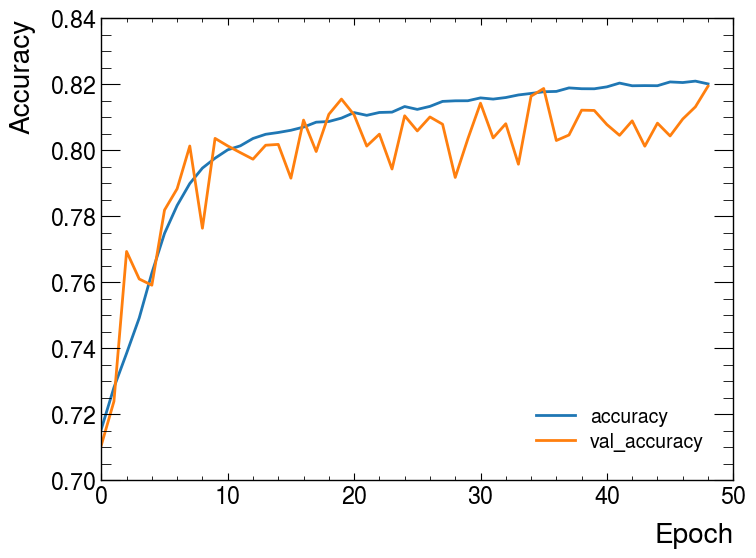

In [21]:
# plot accuracies during the training 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [24]:
# get predictions
pred_test = model.predict(X_test_sc)

Text(0.0, 1.0, 'ROC curve')

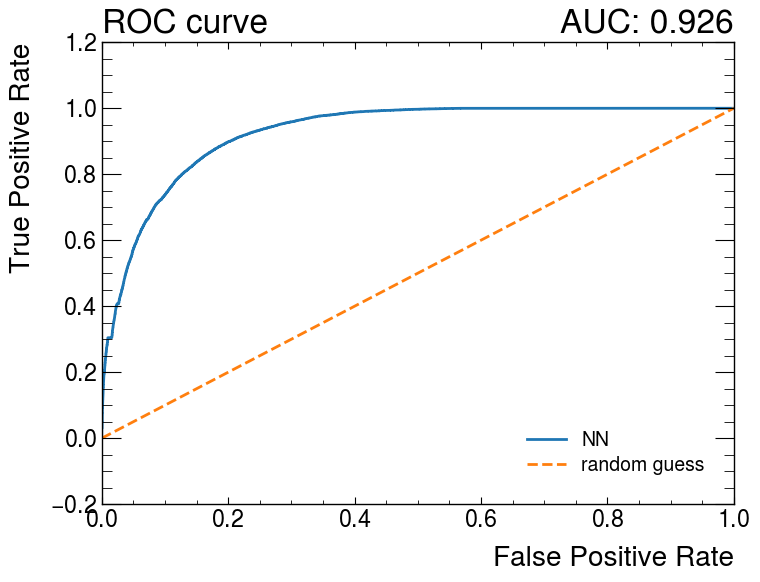

In [27]:
pred_positive = pred_test[:,1]
pred_negative = pred_test[:,0]
# calculate auc
auc = roc_auc_score(y_test, pred_positive, sample_weight=weights_test)
fpr, tpr, _ = roc_curve(y_test, pred_positive, sample_weight=weights_test)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
# plot ROC curve
plt.plot(fpr, tpr, ls='-', label = 'NN')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve', loc='left')

Text(0.5, 1.0, 'NN probability score')

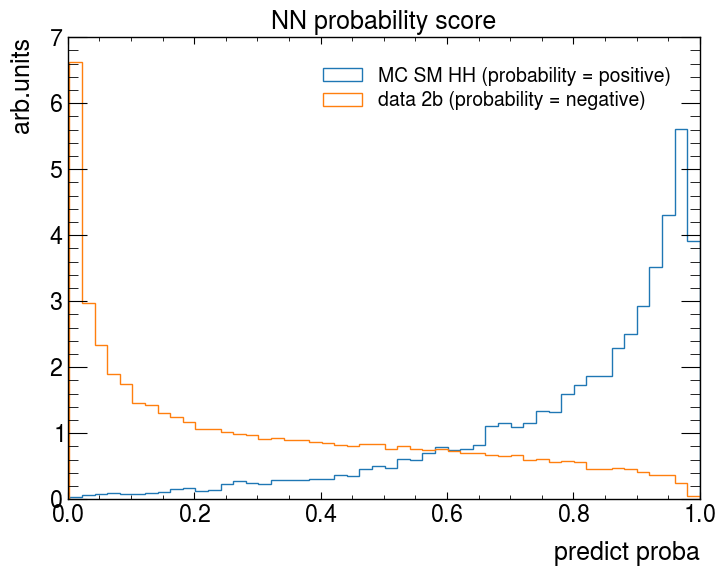

In [28]:
# plot NN probability score
sm_hh_prob = pred_test[:,1][y_test==1]
data_prob = pred_test[:,1][y_test==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 50, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('NN probability score', fontsize=18)

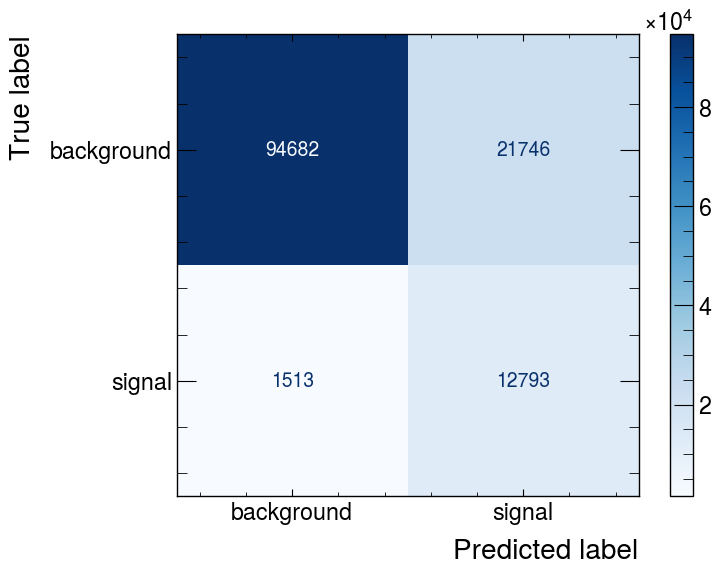

In [30]:
# plot confusion matrix
cm = confusion_matrix(y_test_hot[:,1],pred_test.round()[:,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background', 'signal'])
disp.plot(cmap=plt.cm.Blues)

In [32]:
# calculate f1 socre, precision and recall
f1 = f1_score(y_test_hot.astype(int)[:,1],pred_test.round().astype(int)[:,1])
precision = precision_score(y_test_hot.astype(int)[:,1],pred_test.round().astype(int)[:,1])
recall = recall_score(y_test_hot.astype(int)[:,1],pred_test.round().astype(int)[:,1])
print(f"f1={f1}, precision={precision}, recall={recall}")

f1=0.5238202477223871, precision=0.3703928891977185, recall=0.8942401789458968


In [33]:
# print the JS visualization code to the notebook
shap.initjs()

In [35]:
# Create the list of all labels for the drop down list
list_of_labels = features

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                                 # value 1 for signal, 0 for bkg
                                 value=1,
                                 description='Select Label:'
                                 )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', index=1, options=(('m_hh', 0), ('X_hh', 1), ('dEta_hh', 2), ('njets', 3)…

In [38]:
# calculate SHAP exaplainer
explainer = shap.KernelExplainer(model = model.predict, data = X_train_sc[0:100])

# Note: We are limiting to the first 100 training examples 
# since it takes time to calculate the full number of sampels
shap_values = explainer.shap_values(X = X_train_sc[0:100], nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

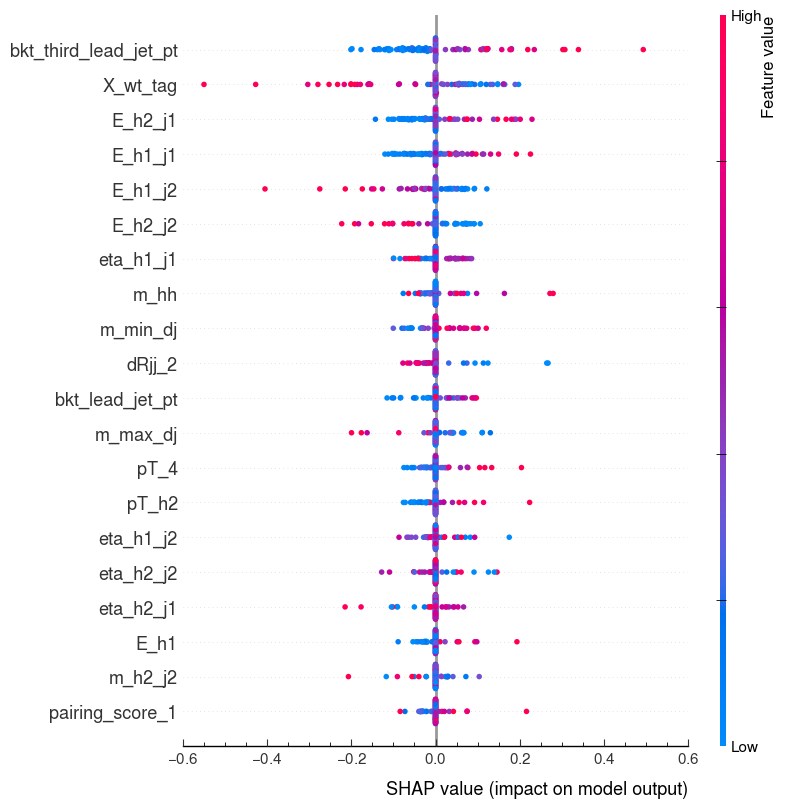

In [39]:
# plot features values
# note that SHAP is not very well adapted for tf models, better for xgboost
shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = X_train_sc[0:100,:], feature_names = features,
                  # max number of features display
                  max_display=20
                  )

# <a id="hp"></a> 4. Hyperparameter tuning

Run main.py to tune the hyperparamters, note that one may want to change the model name and the working directory. Each tuner should have its onw project directory.

In [10]:
# load the best model
# this_is_final_best_model is the name of the best model
model = tf.keras.models.load_model('this_is_final_best_model/', custom_objects={'F1_Score':utils.F1_Score})

2021-09-26 23:00:26.249559: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-26 23:00:26.279561: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-26 23:00:26.279644: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gpu01
2021-09-26 23:00:26.279654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gpu01
2021-09-26 23:00:26.279815: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2021-09-26 23:00:26.279863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2021-09-26 23:00:26.279871: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.32.3
2021-09-26 23:00:26.280314: I tensorflow/core/platform/cpu_feature_guard

To see more information about the model, load the tuner using the working directory. Important, overwrite=False.

In [11]:
tuner = BayesianOptimization(
    utils.build_model,
    objective=Objective('val_f1_score', direction='max'),
    max_trials=1,
    project_name="/mnt/storage/zcapxke/keras_tuner/this_is_final_project/"
)

INFO:tensorflow:Reloading Oracle from existing project /mnt/storage/zcapxke/keras_tuner/this_is_final_project/oracle.json
INFO:tensorflow:Reloading Tuner from /mnt/storage/zcapxke/keras_tuner/this_is_final_project/tuner0.json


In [12]:
# note that for the best model, num_layers: 2
# but it is also showing units_3, rate_3, etc
# there are really two layers, there is not a 3rd or 4th layer
tuner.results_summary()

Results summary
Results in /mnt/storage/zcapxke/keras_tuner/this_is_final_project/
Showing 10 best trials
Objective(name='val_f1_score', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
act_0: relu
rate_0: 0.0
units_1: 500
act_1: tanh
rate_1: 0.0
units_2: 500
act_2: relu
rate_2: 0.4
act_output: softmax
learning_rate: 0.01
units_3: 500
act_3: tanh
rate_3: 0.4
Score: 0.558294415473938
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
act_0: relu
rate_0: 0.0
units_1: 500
act_1: tanh
rate_1: 0.0
units_2: 500
act_2: tanh
rate_2: 0.0
act_output: softmax
learning_rate: 0.01
units_3: 500
act_3: tanh
rate_3: 0.4
units_4: 500
act_4: relu
rate_4: 0.4
Score: 0.5558022061983744
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
act_0: relu
rate_0: 0.0
units_1: 100
act_1: relu
rate_1: 0.0
units_2: 50
act_2: tanh
rate_2: 0.4
act_output: softmax
learning_rate: 0.01
units_3: 50
act_3: relu
rate_3: 0.0
units_4: 500
act_4: tanh
rate_4: 0.4
Score: 0.553094585736592

In [13]:
# more detailed information here
# model.get_config()
# model.weights

# to load another model from the working directory
# i is the number of best model: 0 is first best, 1 is second best, etc
# this can be used to compare different models
# tuner.get_best_models(num_models=num_models)[i]

# <a id="cr"></a> 5. Control region

In [14]:
# get data in control region
data16,data17,data18=utils.get_data(file_path_data_16,file_path_data_17,file_path_data_18,region='control')

100%|████████████████████████████████████████████████████████████████████████████████████████| 466/466 [01:35<00:00,  4.89it/s]


In [15]:
# apply different masks
bkg_2b_df=utils.get_data_mask(data16,data17,data18,mask='2bRW')
bkg_4b_df=utils.get_data_mask(data16,data17,data18,mask='4b')

# weights for 2bRW
weights_2b = bkg_2b_df['sample_weight']

In [16]:
# prepare inputs for model and scale
X_2b = bkg_2b_df[features]
X_4b = bkg_4b_df[features]
X_2b_sc = scaler.fit_transform(X_2b)
X_4b_sc = scaler.fit_transform(X_4b)

In [17]:
# get predictions
pred_test_2b = model.predict(X_2b_sc)[:,1]
pred_test_4b = model.predict(X_4b_sc)[:,1]

2021-09-26 23:03:49.278282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-26 23:03:49.278769: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3200235000 Hz


Text(0.5, 1.0, 'Optimal NN probability in CR')

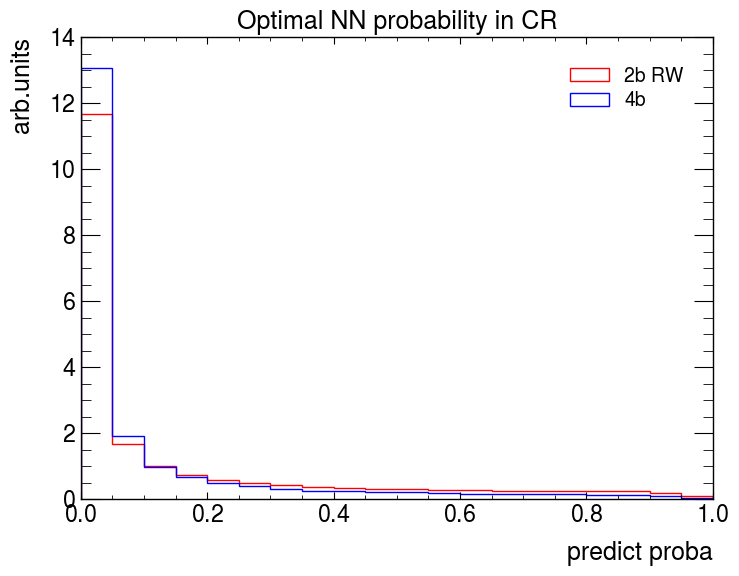

In [18]:
# calculate bins
bins = np.linspace(0.0,1.0,21)
# plot NN socores
h1,_,_ = plt.hist(pred_test_2b, bins = bins, histtype='step',label='2b RW', density= True,
                   weights=weights_2b, color='r')
h2,_,_ = plt.hist(pred_test_4b, bins = bins, histtype='step', label = '4b', density = True, color='b')
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('Optimal NN probability in CR', fontsize=18)

Text(0.5, 1.0, 'Optimal NN probability in CR')

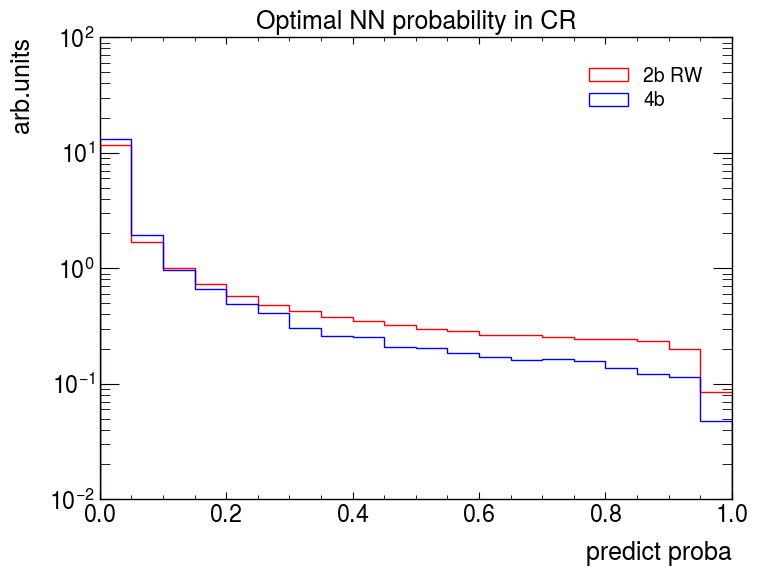

In [19]:
# plot NN socores in log scale
h1,_,_ = plt.hist(pred_test_2b, bins = bins, histtype='step',label='2b RW', density = True,
                   weights=weights_2b, color='r', log = True)
h2,_,_ = plt.hist(pred_test_4b, bins = bins, histtype='step', label = '4b', density = True, color='b', log = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('Optimal NN probability in CR', fontsize=18)

In [20]:
# save weights for scaling 2bRW
np.savetxt('weights.txt', h2/h1, delimiter=',')

For shifted regions plots, run shifted_plots.py

# <a id="remarks"></a> 6. Some remarks

<div class="alert alert-block alert-success">
Best model trained in the SR may not be the best in CR (and other regions). Therefore, one could use the n best models in the tuner  and validate all of them in the CR region. This needs to be studied further.
  
This notebook uses TensorFlow models. XGBoost was also used initially and seemed to work well. However, after  the validation in CR and the exclusion of some features, XGboost seems to work worse. Further study might be done using XGBoost to see if similar level of performance can be accomplished.